# **Lung and Colon Cancer Image Classification using Convolutional Neural Network**

### The notebook contains a default pipeline and computer vision pipeline which includes a convolutional neural network (CNN) model with two different training techniques.

## Problem Statement

Accurate and timely diagnosis of cancer is crucial for effective treatment and improved patient outcomes. This notebook addresses the challenge of differentiating between lung and colon cancer using histopathological images. The aim is to develop a robust deep learning solution that can automate the classification process, potentially assisting pathologists and reducing diagnostic errors. Following are the classes of this dataset,
- Lung benign tissue
- Lung adenocarcinoma
- Lung squamous cell carcinoma
- Colon adenocarcinoma
- Colon benign tissue


## Objectives

- Preprocess the Lung and Colon Cancer Histopathological Images dataset to ensure quality and consistency for model training. https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images 

- Build a self-defined Convolutional Neural Network (CNN) from scratch, capable of extracting meaningful features from histopathological images.

- Train and validate the CNN on the dataset to classify images into respective cancer types (lung vs colon).

- Evaluate the model’s performance using appropriate metrics such as accuracy, precision, recall, and F1-score.

- Visualize model predictions and highlight correctly and incorrectly classified examples to interpret the model’s strengths and limitations.


## 1. Data Installation

In [1]:
# Downloading the Dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/lung-and-colon-cancer-histopathological-images")

print("Path to dataset files:", path)

c:\Users\ometh\anaconda3\envs\ai_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\ometh\.cache\kagglehub\datasets\andrewmvd\lung-and-colon-cancer-histopathological-images\versions\1


## 2. Import requird modules

In [2]:
import torch
import torchvision
import torch.nn as nn 
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import timm 

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np

## 3. Data Preprocessing and Normalization

In [3]:
class CancerDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        return self.data[index]
    
    @property
    def classes(self):
        return self.data.classes
    
    @property
    def targets(self):
        return self.data.targets

In [4]:
data_dir = r'C:\Users\ometh\.cache\kagglehub\datasets\andrewmvd\lung-and-colon-cancer-histopathological-images\versions\1\lung_colon_image_set'
dataset = CancerDataset(data_dir)

In [5]:
indices = list(range(len(dataset)))
labels = dataset.targets  # get class indices

# Split the train 70% 
train_idx, temp_idx, train_labels, temp_labels = train_test_split(
    indices, labels,
    test_size=0.3,
    stratify=labels, #take same propotion from each class
    random_state=42
)

# Split the rest into 50%
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    stratify=temp_labels, #split by same propotion from each class
    random_state=42
)


In [6]:
# Define Data augmentations
# Grayscale version of transforms

# TRAIN
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Grayscale(num_output_channels=3), #Greyscaling
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) #Normalization
])

# VALIDATION
val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=3), #Greyscaling
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) #Normalization
])

# TEST
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=3), #Greyscaling
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) #Normalization
])

train_dataset = Subset(ImageFolder(root=data_dir, transform=train_transform), train_idx)
val_dataset   = Subset(ImageFolder(root=data_dir, transform=val_transform), val_idx)
test_dataset  = Subset(ImageFolder(root=data_dir, transform=test_transform), test_idx)

# Print the lenght of each dataset
print(len(train_dataset), len(val_dataset), len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

17500 3750 3750


In [7]:
# Checking the class imbalance
from collections import Counter

def class_counts(subset, all_classes):
    labels = [subset.dataset.targets[i] for i in subset.indices]
    counts = Counter(labels)
    return {all_classes[i]: counts[i] for i in range(len(all_classes))}

print("Train:", class_counts(train_dataset, dataset.classes))
print("Val:  ", class_counts(val_dataset, dataset.classes))
print("Test: ", class_counts(test_dataset, dataset.classes))


Train: {'colon_aca': 3500, 'colon_n': 3500, 'lung_aca': 3500, 'lung_n': 3500, 'lung_scc': 3500}
Val:   {'colon_aca': 750, 'colon_n': 750, 'lung_aca': 750, 'lung_n': 750, 'lung_scc': 750}
Test:  {'colon_aca': 750, 'colon_n': 750, 'lung_aca': 750, 'lung_n': 750, 'lung_scc': 750}


In [8]:
# Display the size of the images and labels
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)

torch.Size([32, 3, 128, 128]) torch.Size([32])


Training Dataset



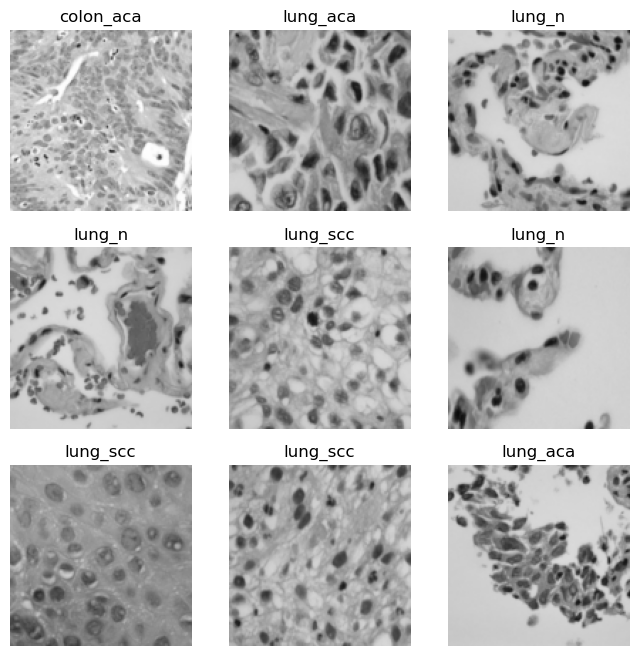

Testing Dataset



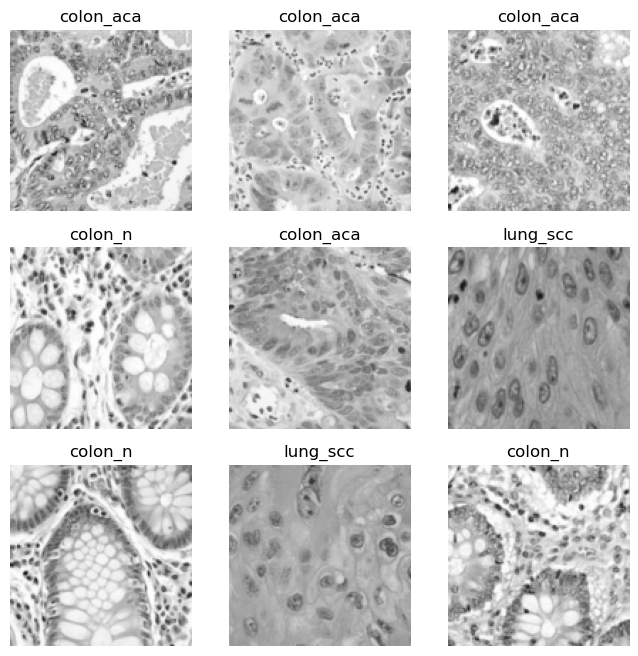

In [9]:
# Method to visualise the images 
def visualise_images(loader, classes, n=9):
    images, labels = next(iter(loader))
    images, labels = images[:n], labels[:n]

    # reversing the normalisation
    mean = torch.tensor([0.5, 0.5, 0.5]).view(3,1,1) 
    std = torch.tensor([0.5, 0.5, 0.5]).view(3,1,1)
    images = images * std + mean

    fig, axes = plt.subplots(3, 3, figsize=(8,8))
    for i, ax in enumerate(axes.flat):
        img = images[i].permute(1, 2, 0).numpy()
        ax.imshow(img)
        ax.set_title(classes[labels[i]])
        ax.axis("off")
    plt.show()

# Training Dataset Visualisation
print("Training Dataset\n")
visualise_images(train_loader, dataset.classes)

# Testing Dataset Visualisation
print("Testing Dataset\n")
visualise_images(test_loader, dataset.classes)

## **Initializing the Convolutional Neural Network**

In [ ]:
# Defining the CNN model
class CNN(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # 224
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 112

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 56

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 28

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 14
        )
        self.pool = nn.AdaptiveAvgPool2d(1) #[B, C, 1, 1]
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes) # logits
        )

    # Forward propogation
    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x

In [ ]:
# Check whether CPU or CUDA(GPU) will used to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)   
print(device)

cuda


In [ ]:
! pip install torchinfo

from torchinfo import summary

model = CNN(num_classes=5).to(device)

# summary(model, input_size=(batch, channels, height, width))
# Display of defined layers
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 5]                    --
├─Sequential: 1-1                        [1, 256, 14, 14]          --
│    └─Conv2d: 2-1                       [1, 32, 224, 224]         896
│    └─BatchNorm2d: 2-2                  [1, 32, 224, 224]         64
│    └─ReLU: 2-3                         [1, 32, 224, 224]         --
│    └─MaxPool2d: 2-4                    [1, 32, 112, 112]         --
│    └─Conv2d: 2-5                       [1, 64, 112, 112]         18,496
│    └─BatchNorm2d: 2-6                  [1, 64, 112, 112]         128
│    └─ReLU: 2-7                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-8                    [1, 64, 56, 56]           --
│    └─Conv2d: 2-9                       [1, 128, 56, 56]          73,856
│    └─BatchNorm2d: 2-10                 [1, 128, 56, 56]          256
│    └─ReLU: 2-11                        [1, 128, 56, 56]          --
│   

In [ ]:
# training method
import os

def train_model(model, train_loader, val_loader, criterion,
                optimizer_class, lr=0.0001, weight_decay=1e-2,
                scheduler_class=None, scheduler_params=None,
                device="cuda", num_epochs=50, print_batch=10,
                save_dir="checkpoints"):

    # List store losses and accuarcies
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    model = model.to(device) #assigning the model train using GPU
    optimizer = optimizer_class(model.parameters(), lr=lr, weight_decay=weight_decay)

    # scheduler 
    scheduler = None
    if scheduler_class is not None:
        scheduler = scheduler_class(optimizer, **scheduler_params)

    # EPOCH loop
    for epoch in range(num_epochs):
        # ----- Training -----
        model.train()
        running_loss = 0.0 
        correct_samples = 0 
        total = 0
        
        for i, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)

            logits = model(x)
            loss = criterion(logits, y)
            
            # Backward propagation with optimize steps
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * y.size(0)
            preds = torch.argmax(logits, dim=1)
            correct_samples += (preds == y).sum().item()
            total += y.size(0)

            # Output every 10 batch using modulo
            if (i+1) % print_batch == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], "
                      f"Step [{i+1}/{len(train_loader)}], "
                      f"Loss: {loss.item():.4f}")

        epoch_loss = running_loss / total
        epoch_acc = correct_samples / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        print(f"Epoch [{epoch+1}/{num_epochs}] finished. "
              f"Avg Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")
        
        # ----- Validation -----
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                loss = criterion(logits, y)
                
                val_loss += loss.item() * y.size(0)
                preds = torch.argmax(logits, dim=1)
                val_correct += (preds == y).sum().item()
                val_total += y.size(0)

        avg_val_loss = val_loss / val_total
        avg_val_acc = val_correct / val_total
        val_losses.append(avg_val_loss)
        val_accs.append(avg_val_acc)

        if scheduler:
            scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}")

        # ----- Save checkpoint every 5 epochs -----
        if (epoch + 1) % 5 == 0:
            # create unique folder for each epoch
            save_path = os.path.join(save_dir, f"epoch_{epoch+1}")
            os.makedirs(save_path, exist_ok=True)

            # save model, optimizer, scheduler separately
            torch.save(model.state_dict(), os.path.join(save_path, "model.pth"))
            torch.save(optimizer.state_dict(), os.path.join(save_path, "optimizer.pth"))
            if scheduler is not None:
                torch.save(scheduler.state_dict(), os.path.join(save_path, "scheduler.pth"))

            # keep track of epoch metadata
            torch.save({
                "epoch": epoch+1,
                "train_loss": epoch_loss,
                "val_loss": avg_val_loss,
                "train_acc": epoch_acc,
                "val_acc": avg_val_acc
            }, os.path.join(save_path, "metrics.pth"))

            print(f"Checkpoint saved at {save_path}")

    return train_losses, val_losses, train_accs, val_accs


In [ ]:
# val accuracy and loss plot function
def plot_metrics(train_acc, val_acc, train_loss, val_loss):
    epochs_range = range(1, len(train_acc) + 1)

    # Accuracy plot
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, train_acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right') 
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

    # Loss plot
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, train_loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()


In [ ]:
import seaborn as sns

# eval model function
class_names = ["colon_aca", "colon_n", "lung_aca", "lung_n", "lung_scc"]

def eval_model(model, test_loader, class_names, device="cuda"):
    model.eval()  # set to eval mode
    y_true, y_pred = [], []

    with torch.no_grad():  # no gradient calculation needed
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device) #using GPU for eval

            logits = model(images)  # forward pass
            preds = torch.argmax(logits, dim=1)  # predicted classes

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # Classification report
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    print("\nClassification Report:\n", report)

### Train using a Fixed Learning Rate

In [ ]:
# Defining the Criterion and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW

train_losses, val_losses, train_accs, val_accs = train_model(
                                                    model,
                                                    train_loader=train_loader,
                                                    val_loader= val_loader,
                                                    criterion=criterion,
                                                    optimizer_class=optimizer,
                                                    lr=1e-3,
                                                    weight_decay=1e-2,
                                                    scheduler_class=None,
                                                    device="cuda",
                                                    num_epochs=50
                                                )

Epoch [1/50], Step [10/547], Loss: 0.9276
Epoch [1/50], Step [20/547], Loss: 0.8574
Epoch [1/50], Step [30/547], Loss: 0.6144
Epoch [1/50], Step [40/547], Loss: 0.6235
Epoch [1/50], Step [50/547], Loss: 0.5413
Epoch [1/50], Step [60/547], Loss: 0.4711
Epoch [1/50], Step [70/547], Loss: 0.6648
Epoch [1/50], Step [80/547], Loss: 0.5057
Epoch [1/50], Step [90/547], Loss: 0.3855
Epoch [1/50], Step [100/547], Loss: 0.7557
Epoch [1/50], Step [110/547], Loss: 0.6280
Epoch [1/50], Step [120/547], Loss: 0.3296
Epoch [1/50], Step [130/547], Loss: 0.3635
Epoch [1/50], Step [140/547], Loss: 0.6441
Epoch [1/50], Step [150/547], Loss: 0.2890
Epoch [1/50], Step [160/547], Loss: 0.5056
Epoch [1/50], Step [170/547], Loss: 0.3700
Epoch [1/50], Step [180/547], Loss: 0.4441
Epoch [1/50], Step [190/547], Loss: 0.2221
Epoch [1/50], Step [200/547], Loss: 0.4759
Epoch [1/50], Step [210/547], Loss: 0.3058
Epoch [1/50], Step [220/547], Loss: 0.2369
Epoch [1/50], Step [230/547], Loss: 0.3201
Epoch [1/50], Step [

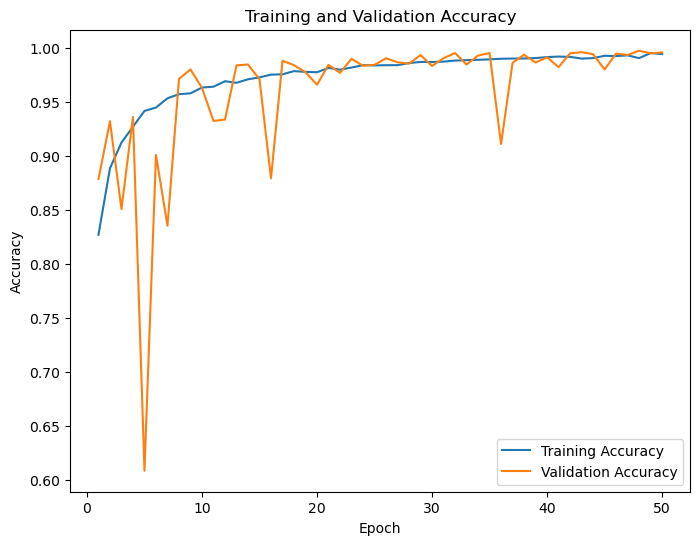

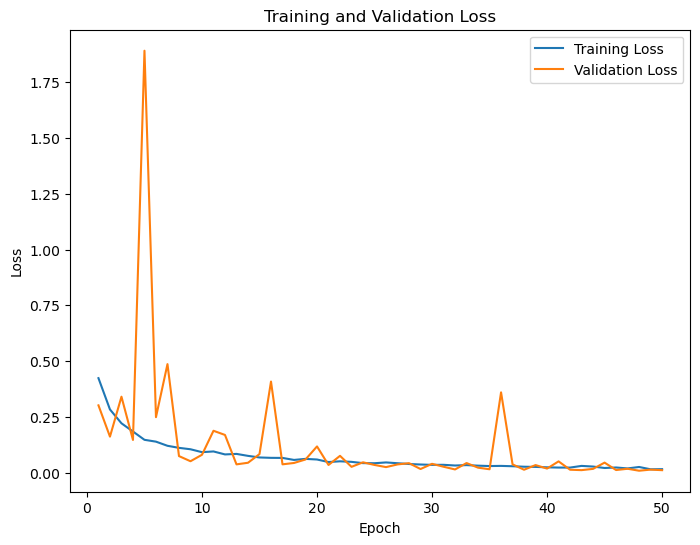

In [43]:
plot_metrics(train_accs, val_accs, train_losses, val_losses)

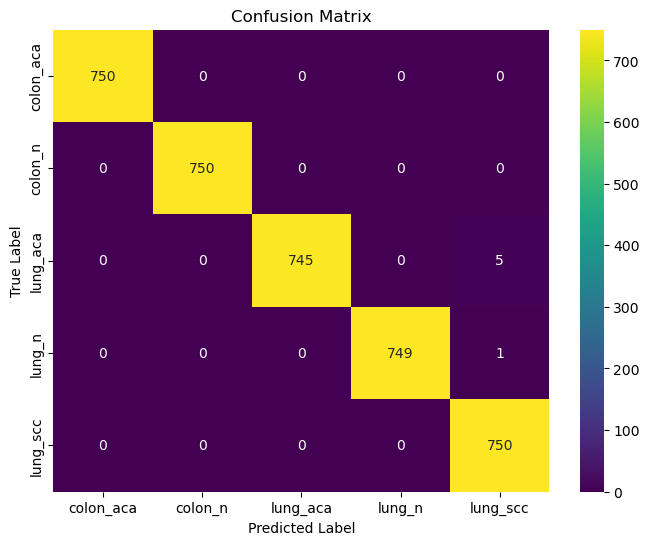


Classification Report:
               precision    recall  f1-score   support

   colon_aca     1.0000    1.0000    1.0000       750
     colon_n     1.0000    1.0000    1.0000       750
    lung_aca     1.0000    0.9933    0.9967       750
      lung_n     1.0000    0.9987    0.9993       750
    lung_scc     0.9921    1.0000    0.9960       750

    accuracy                         0.9984      3750
   macro avg     0.9984    0.9984    0.9984      3750
weighted avg     0.9984    0.9984    0.9984      3750



In [44]:
eval_model(model, test_loader, class_names, device=device)

### Train using a Learning rate schedule

In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR

train_losses, val_losses, train_accs, val_accs = train_model(
                                                    model,
                                                    train_loader=train_loader,
                                                    val_loader= val_loader,
                                                    criterion=criterion,
                                                    optimizer_class=optimizer,
                                                    lr=1e-3,
                                                    weight_decay=1e-2,
                                                    scheduler_class=scheduler,
                                                    device="cuda",
                                                    num_epochs=50,
                                                    scheduler_params = {"T_max": 50},
                                                    save_dir="Output_with_scheduler"
                                                )

Epoch [1/50], Step [10/547], Loss: 0.0144
Epoch [1/50], Step [20/547], Loss: 0.0001
Epoch [1/50], Step [30/547], Loss: 0.0104
Epoch [1/50], Step [40/547], Loss: 0.0008
Epoch [1/50], Step [50/547], Loss: 0.0519
Epoch [1/50], Step [60/547], Loss: 0.0022
Epoch [1/50], Step [70/547], Loss: 0.0022
Epoch [1/50], Step [80/547], Loss: 0.0007
Epoch [1/50], Step [90/547], Loss: 0.0009
Epoch [1/50], Step [100/547], Loss: 0.0013
Epoch [1/50], Step [110/547], Loss: 0.0074
Epoch [1/50], Step [120/547], Loss: 0.0036
Epoch [1/50], Step [130/547], Loss: 0.0004
Epoch [1/50], Step [140/547], Loss: 0.0010
Epoch [1/50], Step [150/547], Loss: 0.0036
Epoch [1/50], Step [160/547], Loss: 0.0473
Epoch [1/50], Step [170/547], Loss: 0.0006
Epoch [1/50], Step [180/547], Loss: 0.0050
Epoch [1/50], Step [190/547], Loss: 0.0010
Epoch [1/50], Step [200/547], Loss: 0.0007
Epoch [1/50], Step [210/547], Loss: 0.0124
Epoch [1/50], Step [220/547], Loss: 0.0009
Epoch [1/50], Step [230/547], Loss: 0.0137
Epoch [1/50], Step [

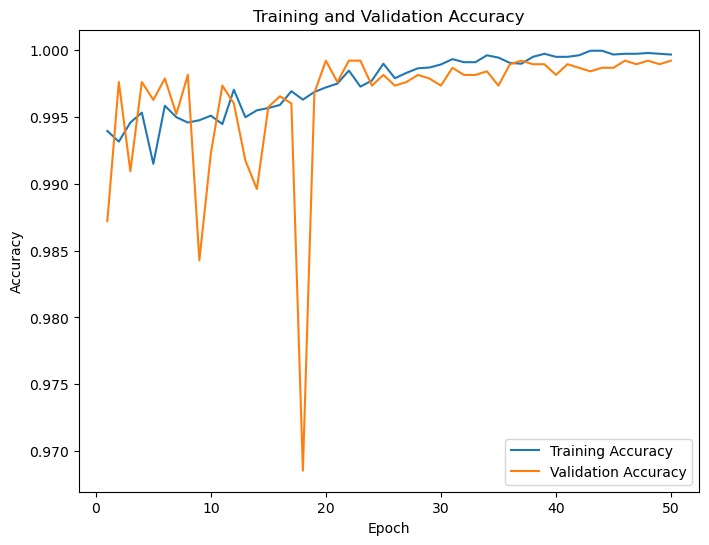

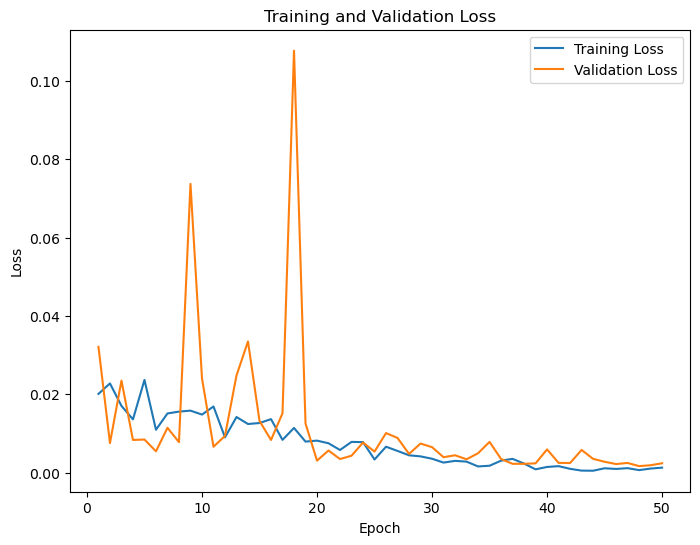

In [46]:
plot_metrics(train_accs, val_accs, train_losses, val_losses)

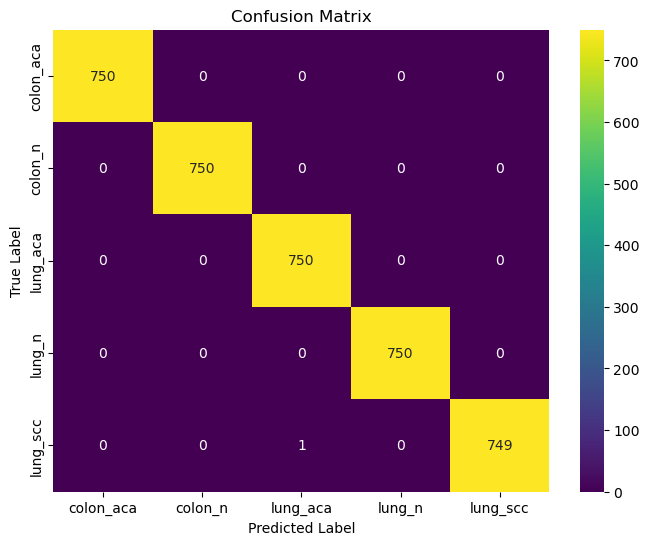


Classification Report:
               precision    recall  f1-score   support

   colon_aca     1.0000    1.0000    1.0000       750
     colon_n     1.0000    1.0000    1.0000       750
    lung_aca     0.9987    1.0000    0.9993       750
      lung_n     1.0000    1.0000    1.0000       750
    lung_scc     1.0000    0.9987    0.9993       750

    accuracy                         0.9997      3750
   macro avg     0.9997    0.9997    0.9997      3750
weighted avg     0.9997    0.9997    0.9997      3750



In [ ]:
eval_model(model, test_loader, class_names, device=device)